<img src="image.png" style="width:350px;height:70pz"/>

# Diploma Thesis
## "MOSFET modeling as a digital twin and use of Machine Learning models to find current leakage"
### Instructor: Charalampos Z. Patrikakis  👩‍🏫
### Author: Ηenri Xhindi 👨‍🎓

### Purpose of work 📚
Τhis work demostrates the potential of digital twins in the industry as well as how they can be simulated and trained with A.I. methods. 
Digital twin modeling does not necessarily need tools from data science or machine learning. However, it is prudent to use such modeling techniques wherever applicable and suitable. In our case we will make a digital twin of a MOSFET and later on we will use Deep Learning models on it. The target of this work is that by creating the digital twin, it can allows you to swap out an analytical model with an Machine Learning model (and vice versa).

More precisely, with using an ML technique, we are going to predict the  Sub-Threshold leakage of a MOSFET, a phenomenon found in all MOSFETs. Later on, it is going to get discussed with more details.



## A little bit of theory 🤓

#### Digital Twins  🧑🧑

Digital twins can be digital replicas-representations of physical objects, processes or services of the physical world, such as jet engines, wind farms, or even larger items such as buildings or even whole cities.
As well as physical assets, digital twin objects can be used to replicate processes in order to collect data to predict how they will perform.

#### Machine Learning 🤖

Machine Learning is a subfield of computer science that is developed from the study of pattern recognition and computational learning theory in artificial intelligence. Machine learning explores the study and construction of algorithms that can learn from data and make predictions about it. This kind of algorithms work by building models from experimental data in order to make predictions.

#### Deep Learning 🧠

Deep learning is a type of machine learning based on artificial neural networks that imitates the way humans gain certain types of knowledge. Deep learning is an important element of data science, which includes statistics and predictive modeling. We will use Deep Learning methods on this project in ourder to train our digital twin.

#### MOSFET  🖥️

Transistors are semiconductor devices used to amplify or switch electrical signals and power. Also, they are one of the basic building blocks of modern electronics.
Most modern transistors are Metal-Oxide-Semiconductor Field-Effect-Transistor (MOSFET). Basically, MOSFET is a device made of metal and semiconductor layers (usually silicon-Si or germanium-Ge) that sandwich an electrical insulator material layer in between (usually a thin oxide).

<img src="MOSFET_Structure.png" style="width:350px;height:70pz"/>


Practically the MOSFET is a digital switch.To be more precise, if the voltage between Gate (G) and Source (S) is below a certain threshold, then the switch is OFF (0-zero) and no current flows between the Drain and Source. In contrary when the Gate (G) to Source (S) voltage is above this threshold, the switch is ON (1-one). Furthermore, the Drain (D) to Source (S) current is also determined by the voltage between them.
So, the fundamental utility of a MOSFET is as a voltage-controlled switch i.e. we can control the amount of current (or information) between two of its terminals by controlling the voltage on the third terminal.

### Characteristics we want to model


When developing a digital twin, the characteristics we should consider is one of the most important parts of the development. This determines the complexity and data structure choice for our digital twin.

In our project, for the sake of simplicity, we will consider modeling only the most bacics charecteristics. Although we can model all kinds of complex physics phenomena with the MOSFET structure, we will work with the drain-source current (Ids) and voltage (Vds) relationships in their simplest form.



## Let the coding begin 👨‍💻

#### Importing the necessary libraries 📕

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler

%matplotlib inline

#### Definition of constant - fixed parameters ⚡

In [2]:
# Function for sub-Vth(threshold leakage) calculation
def sub_vth(W_L,Vgs,Vth,temp=300):
    
    # Initialization of parameters to simulate the measurement noise and manufacturing/material variability

    # Electron charge
    q = 1.60218e-19
    
    # Boltzman constant
    k = 1.3806e-23
    
    
    
    # W_L & eta gets randomized to mimic material and manufacturing variability
    # We are using the numpy library in order to achive that. 
    
    # Capacitance factor
    eta = 1.2+0.01*np.random.normal()
    
    # Mobility factor/coefficient
    W_L = W_L*(1+0.01*np.random.normal())
    
    
    return W_L*np.exp(q*(Vgs-Vth)/(eta*k*temp))

#### Declaration of MOSFET class 📟

In [3]:
class MOSFET:
    def __init__(self,params=None,terminals=None):
          
        """
        The followings parameters are considered some of the most important parameters
        of a generic MOSFET.
    
        Vth --> The threshold voltage between Gate and Source of the MOSFET in which is ON
        gm  --> The convenience of the MOSFET to carry current between Drain and Source when it's ON
        BV  --> The breakdown voltage shows how much voltage the MOSFET can hold between its Drain 
        and Source while it is in the OFF state.    
        """
        
        # Params
        if params is None:
            self._params_ = {'BV':20,
                             'Vth':1.0,
                             'gm':1e-2}
        else:
            self._params_ = params
            
            
        
        # Terminals
        if terminals is None:
            self._terminals_ = {'Source':0.0,
                        'Drain':0.0,
                        'Gate':0.0}
        else:
            self._terminals_ = terminals
            
        
        # Determine state
        self._state_ = self.determine_state()
        
        # Leakage model trained?
        self._leakage_ = False
        self.leakage_model = None
        
#-------------------------------------------------------------------------
## With the following method we can describe the object in one line.

    def __repr__(self):
        return "MOSFET's Digital Twin"

    
#-------------------------------------------------------------------------    
## With the following method we can determine the Switching State (ON/OFF) of the MOSFET.

    def determine_state(self,Vgs=None):

        if Vgs is None:
            Vgs = self._terminals_['Gate'] - self._terminals_['Source']
        else:
            Vgs = Vgs
        if Vgs > self._params_['Vth']:
            return 'ON'
        else:
            return 'OFF'

        
#-------------------------------------------------------------------------    
## Calculation of the Drain-Source Current of the MOSFET using the terminal voltages and gm.

    def Id_Vd(self,Vgs=None,Vds=None,rounding=True):
       
        if Vds is None:
            Vds = self._terminals_['Drain'] - self._terminals_['Source']
        else:
            Vds = Vds
        if Vgs is None:
            Vgs = self._terminals_['Gate'] - self._terminals_['Source']
        else:
            Vgs = Vgs
        
        Vth = self._params_['Vth']
        state = self.determine_state(Vgs=Vgs)
        self._state_ = state
        
        if state=='ON':
            if Vds <= Vgs - Vth:
                Ids = self._params_['gm']*(Vgs - Vth - (Vds/2))*Vds
            else:
                Ids = (self._params_['gm']/2)*(Vgs-Vth)**2
            if rounding:
                return round(Ids,3)
            else:
                return Ids
        else:
            return sub_vth(W_L=self._params_['gm'],
                           Vgs=Vgs,
                           Vth=Vth)
        

#-------------------------------------------------------------------------    
## Calculates Rdson i.e. on-state resistance of the MOSFET


    def rdson(self,Vgs=None,Vds=None):

        if Vds is None:
            Vds = self._terminals_['Drain'] - self._terminals_['Source']
        else:
            Vds = Vds
        if Vgs is None:
            Vgs = self._terminals_['Gate'] - self._terminals_['Source']
        else:
            Vgs = Vgs
        
        Ids = self.Id_Vd(Vgs=Vgs,Vds=Vds,rounding=False)
        Vds_delta = Vds+0.001
        Ids_delta = self.Id_Vd(Vgs=Vgs,Vds=Vds_delta,rounding=False)
        rdson = 0.001/(Ids_delta-Ids)
        
        return round(rdson,3)
    
    
#-------------------------------------------------------------------------    
## Training of our model with Deep Learning 
## Now we are going to train the digital twin as a model with leakage current using experimental data.


    def train_leakage(self,data=None,
                      batch_size=5,
                      epochs=20,
                      learning_rate=2e-5,
                      verbose=1):

        """
            data          --> the training data (Pandas DataFrame)
            batch_size    --> training batch size
            epochs        --> No. of epochs 
            learning_rate --> learning rate 
            verbose       --> verbosity of display while training
        """
                                    
        if data is None:
            return "No data available for training"
        X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled = prepare_data(data,
                                                input_cols=['W_L','Vgs','Vth'],
                                                output_var='log-leakage',
                                                        scaley=False)
        
        # Deep-learning model
        model = build_model(num_layers=3,
                            architecture=[32,32,32],
                            input_dim=3)
        
        # Compile and train
        model_trained = compile_train_model(model,
                                            X_train_scaled,
                                            y_train_scaled,
                                            batch_size=batch_size,
                                            epochs=epochs,
                                            learning_rate=learning_rate,
                                            verbose=verbose)
        
        self.leakage_model = model_trained
        self._leakage_ = True
                        
                      
#-------------------------------------------------------------------------                      
## Separate leakage method to predict the sub-Vth leakage for any combination of transconductance, Vgs, and Vth as input.

    def leakage(self,
                W_L=1e-2,
                Vgs=None,
                Vth=None):
                      
        """
        Calculates leakage current using the deep learning model
        """
                      
        if not self._leakage_:
            return "Leakage model is not trained"
        # Vgs
        if Vgs is None:
            Vgs = self._terminals_['Gate'] - self._terminals_['Source']
        else:
            Vgs = Vgs
        # Vth
        if Vth is None:
            Vth = self._params_['Vth']
        else:
            Vth = Vth
        # Predict
        x = np.array([W_L,Vgs,Vth])
        ip = x.reshape(-1,3)
        result = float(10**(-self.leakage_model.predict(ip)))
        
        
        return result

# CREATING A MOSFET OBJECT

In [4]:
mosfet = MOSFET()


In [5]:
mosfet


MOSFET's Digital Twin

In [6]:
mosfet._state_


'OFF'

In [7]:
mosfet._params_


{'BV': 20, 'Vth': 1.0, 'gm': 0.01}

### Object state changes as terminal voltage assignment varies

In [8]:
mosfet = MOSFET(terminals={'Source':0.0,'Drain':0.0,'Gate':2.0}, 
           params={'BV':20,'Vth':1.0,'gm':1e-2})

In [9]:
mosfet._state_


'ON'

In [10]:
mosfet = MOSFET(terminals={'Source':0.0,'Drain':0.0,'Gate':0.7},
            params={'BV':20,'Vth':1.0,'gm':1e-2})

In [11]:
mosfet._state_


'OFF'

## Declaring Id-Vd values for the MOSFET

In [12]:
# Drain-Source Current
mosfet.Id_Vd(Vgs=0.2,Vds=2.0)

8.458106044849822e-14

In [13]:
# Drain-Source Current
mosfet.Id_Vd(Vgs=3.0,Vds=0.5)

0.009

In [14]:
# Drain-Source Current
mosfet.Id_Vd(Vgs=3.0,Vds=1.0)

0.015

In [15]:
# Drain-Source Current
mosfet.Id_Vd(Vgs=3.0,Vds=3.0)

0.02

In [16]:
# Drain-Source Current
mosfet.Id_Vd(Vgs=3.0,Vds=4.0)

0.02

In [17]:
mosfet._state_

'ON'

In [18]:
# On-state Resistance
mosfet.rdson(Vgs=3.0,Vds=0.5)

66.689

In [19]:
# On-state Resistance
mosfet.rdson(Vgs=3.0,Vds=0.6)

71.454

In [20]:
# On-state Resistance
mosfet.rdson(Vgs=5.0,Vds=1.5)

40.008

## Current (Ids) - Voltage (Vds) Graph Characteristics

- Graph for an ideal MOSFET 

In [21]:
Ids = []
mosfet = MOSFET()
Vds_vals = [0.01*i for i in range(1,501)]
for V in Vds_vals:
    Ids.append(mosfet.Id_Vd(Vgs=3.0,Vds=V,rounding=False))

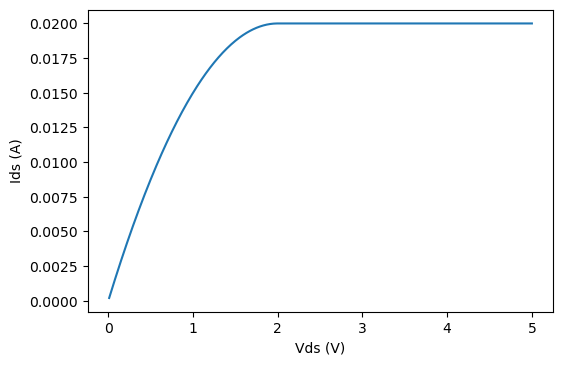

In [22]:
plt.figure(dpi=100)
plt.plot(Vds_vals,Ids)
plt.xlabel("Vds (V)",fontsize=10)
plt.ylabel("Ids (A)",fontsize=10)
plt.show()

- Graph of a more analytical model which contains Vgs (Voltage of Gate-Source).

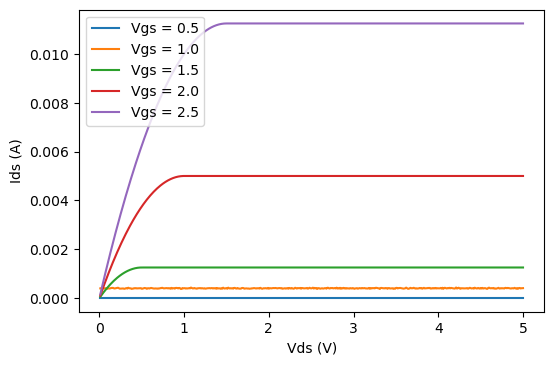

In [23]:
m = MOSFET()
plt.figure(dpi=100)
for Vgs in [0.5,0.9,1.5,2.0,2.5]:
    Ids = []
    Vds_vals = [0.01*i for i in range(1,501)]
    for V in Vds_vals:
        Ids.append(m.Id_Vd(Vgs=Vgs,Vds=V,rounding=False))
    plt.plot(Vds_vals,Ids)
plt.legend(["Vgs = "+str(V) for V in [0.5,1.0,1.5,2.0,2.5]])
plt.xlabel("Vds (V)",fontsize=10)
plt.ylabel("Ids (A)",fontsize=10)
plt.show()

## Importing the Sub-Vth leakage of a MOSFET

The ideal MOSFET, when in OFF state (Vgs is below Vth), must carry zero current between Drain & Source. However, in the reality, due to quantum mechanics, a real MOSFET carries a small amount of ‘leakage’ current even in the OFF state.

For that case, we are going to calculate this current using some ML algorithms and a DNN (deep neural network).



In [24]:
mosfet.train_leakage()


'No data available for training'

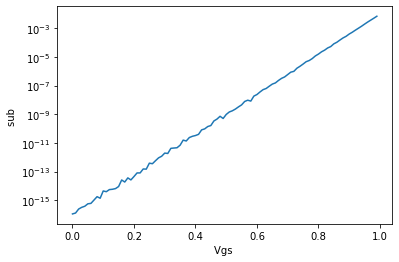

In [25]:
sub = []
Vgs = []
for i in range(100):
    sub.append(sub_vth(W_L=1e-2,Vgs=i*0.01,Vth=1.0))
    Vgs.append(i*0.01)

plt.semilogy(Vgs,sub)
plt.xlabel("Vgs ",fontsize=10)
plt.ylabel("sub ",fontsize=10)
plt.show()

## Importing Synthetic leakage data - Data exploratory

In [26]:
from itertools import product

In [27]:
W_L_list = [1e-3*i for i in range(1,21)]
Vgs_list = [0.01*i for i in range(1,91)]
Vth_list = [0.05*i for i in range(21,31)]

In [28]:
comb = list(product(W_L_list,Vgs_list,Vth_list))

In [29]:
data_dict = {'W_L':[],'Vgs':[],'Vth':[],'sub-Vth':[]}
for c in comb:
    data_dict['W_L'].append(c[0])
    data_dict['Vgs'].append(c[1])
    data_dict['Vth'].append(c[2])
    data_dict['sub-Vth'].append(sub_vth(c[0],c[1],c[2]))

In [30]:
data = pd.DataFrame(data=data_dict,columns=['W_L','Vgs','Vth','sub-Vth'])


In [31]:
# seventh (7th) row(sample) 
data.sample(7).T

,8051,17144,635,9966,15177,2483,4578
W_L,0.009000,2.000000e-02,1.000000e-03,1.200000e-02,1.700000e-02,3.000000e-03,6.000000e-03
Vgs,0.860000,5.000000e-02,6.400000e-01,7.000000e-02,7.800000e-01,6.900000e-01,8.000000e-02
Vth,1.100000,1.250000e+00,1.300000e+00,1.350000e+00,1.400000e+00,1.200000e+00,1.450000e+00
sub-Vth,0.000003,3.873895e-19,5.769680e-13,2.088222e-20,4.566542e-11,2.077474e-10,3.649449e-22


In [32]:
# No. rows=samples, columns=features
data.shape

(18000, 4)

In [33]:
"""
The exponentiation, raising to the power of 10, 
is because we supplied the negative 10-logarithm of actual 
leakage values as training targets to the DNN model. This was done to achieve 
faster convergence and higher accuracy.
"""

data['log-leakage'] = -np.log10(data['sub-Vth'])

In [34]:
# No. rows=samples, columns=features
data.shape

(18000, 5)

In [35]:
# first (10) rows(samples) 
data.head(10)

,W_L,Vgs,Vth,sub-Vth,log-leakage
0,0.001,0.01,1.05,2.801950e-18,17.552540
1,0.001,0.01,1.10,6.650390e-19,18.177153
2,0.001,0.01,1.15,9.605191e-20,19.017494
3,0.001,0.01,1.20,2.546769e-20,19.594010
4,0.001,0.01,1.25,2.160030e-21,20.665540
5,0.001,0.01,1.30,1.212531e-21,20.916307
6,0.001,0.01,1.35,1.402079e-22,21.853227
7,0.001,0.01,1.40,4.480944e-23,22.348630
8,0.001,0.01,1.45,7.617072e-24,23.118212
9,0.001,0.01,1.50,1.179472e-24,23.928312


In [36]:
# general statistics of the datase
data.describe()

,W_L,Vgs,Vth,sub-Vth,log-leakage
count,18000.000000,18000.000000,18000.000000,1.800000e+04,18000.000000
mean,0.010500,0.455000,1.275000,4.199568e-07,13.560506
std,0.005766,0.259799,0.143618,4.695900e-06,4.171355
min,0.001000,0.010000,1.050000,1.179472e-24,3.778586
25%,0.005750,0.230000,1.150000,1.900807e-17,10.395869
50%,0.010500,0.455000,1.275000,2.745706e-14,13.561346
75%,0.015250,0.680000,1.400000,4.019118e-11,16.721062
max,0.020000,0.900000,1.500000,1.664999e-04,23.928312


## Graphs  📈

We can use different kind of graphs in order to have a better understanding of our dataset and the corellation within its features.

This is a sum of scatter graphs according to our dataset features.

array([[<AxesSubplot:xlabel='W_L', ylabel='W_L'>,
        <AxesSubplot:xlabel='Vgs', ylabel='W_L'>,
        <AxesSubplot:xlabel='Vth', ylabel='W_L'>,
        <AxesSubplot:xlabel='sub-Vth', ylabel='W_L'>,
        <AxesSubplot:xlabel='log-leakage', ylabel='W_L'>],
       [<AxesSubplot:xlabel='W_L', ylabel='Vgs'>,
        <AxesSubplot:xlabel='Vgs', ylabel='Vgs'>,
        <AxesSubplot:xlabel='Vth', ylabel='Vgs'>,
        <AxesSubplot:xlabel='sub-Vth', ylabel='Vgs'>,
        <AxesSubplot:xlabel='log-leakage', ylabel='Vgs'>],
       [<AxesSubplot:xlabel='W_L', ylabel='Vth'>,
        <AxesSubplot:xlabel='Vgs', ylabel='Vth'>,
        <AxesSubplot:xlabel='Vth', ylabel='Vth'>,
        <AxesSubplot:xlabel='sub-Vth', ylabel='Vth'>,
        <AxesSubplot:xlabel='log-leakage', ylabel='Vth'>],
       [<AxesSubplot:xlabel='W_L', ylabel='sub-Vth'>,
        <AxesSubplot:xlabel='Vgs', ylabel='sub-Vth'>,
        <AxesSubplot:xlabel='Vth', ylabel='sub-Vth'>,
        <AxesSubplot:xlabel='sub-Vth', ylabel='su

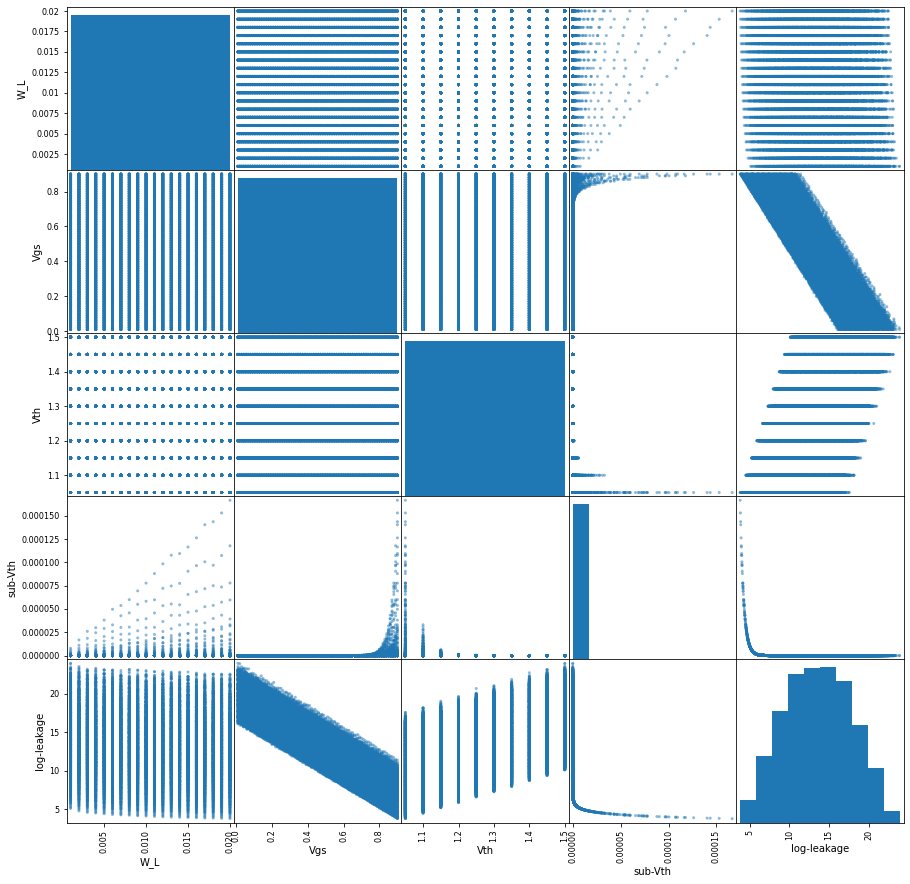

In [37]:
pd.plotting.scatter_matrix(data.iloc[:,:], figsize=(15, 15))

This is a Correlation Matrix of our dataset.

<AxesSubplot:>

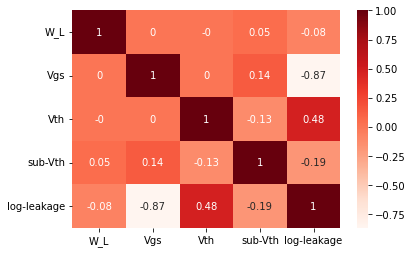

In [38]:
correlation_matrix = data.iloc[:,:].corr().round(2)
sns.heatmap(data=correlation_matrix, annot=True,cmap="Reds")

# Training leakage model 🏋️

From here and on we will be using Machine Learning techniques in order to predict the Sub-Threshold leakage of our MOSFETs.

#### 🆘 Important

We are going to use regression models, as we are talking about finding a numerical value

## Preparing & splitting the dataset into training and testing data  🤖


In [39]:
def prepare_data(data, input_cols,output_var,test_size=0.25,scaley=False):
    
    
    data1 = data.copy()
    X = data1[input_cols]
    y = data1[str(output_var)]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)

    # Min-max scaler from Scikit-learn
    scalerx = MinMaxScaler()
    scalery = MinMaxScaler()
    X_train_scaled = scalerx.fit_transform(X_train)
    X_test_scaled = scalerx.fit_transform(X_test)
    if scaley == True:
        y_train_scaled = scalery.fit_transform(y_train.values.reshape(-1, 1))
        y_test_scaled = scalery.fit_transform(y_test.values.reshape(-1, 1))
    else:
        y_train_scaled = y_train.values.reshape(-1, 1)
        y_test_scaled = y_test.values.reshape(-1, 1)
    
    return (X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled)

In [40]:
X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled = prepare_data(data,
                                                input_cols=['W_L','Vgs','Vth'],
                                                output_var='log-leakage',
                                                        scaley=False)

#### 🆘 Important

The **test_size** is generally expected to be around 20-30 % of the dataset. By changing this number we can see different Succes Rates in our algorithms.After many combinations, we find that one of the best combos has **test_size=0.25**. You can try changing them to see new results for our following Evaluations Models.

## Linear Regression ↗️

#### 1. Importing algorithm's library

In [41]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

#### 2. Select a specific learning algorithm (Linear Regression)

In [42]:
linregressor = LinearRegression()

#### 3. Train our model

In [43]:
linregressor.fit(X_train_scaled, y_train_scaled)

LinearRegression()

#### 4. Model evaluation

In [44]:
from sklearn import metrics
y_pred_lr = linregressor.predict(X_test_scaled)

# mean absolute error
mae=metrics.mean_absolute_error(y_test_scaled, y_pred_lr)
# root mean square error of our model
rmse = (np.sqrt(mean_squared_error(y_test_scaled, y_pred_lr)))
# r-squared score of our model
r2 = r2_score(y_test_scaled, y_pred_lr)
linregressor.score(X_test_scaled, y_test_scaled)

print("Our model performance metrics are the following:")
print("--------------------------------------")
print('Mean Absolute Error= ', mae)  
print('Root Mean Squared Error = ',rmse)
print('R2 score = ',linregressor.score(X_test_scaled, y_test_scaled))

Our model performance metrics are the following:
--------------------------------------
Mean Absolute Error=  0.1233573226158758
Root Mean Squared Error =  0.16038119336260565
R2 score =  0.9984691563886553


## 🇰- Nearest Neighbors Regression

#### 1. Importing algorithm's library

In [45]:
from sklearn.neighbors import KNeighborsRegressor

#### 2. Select a specific learning algorithm (K-Nearest Neighbors Regression) & set hyperparameters

In [46]:
knnReg = KNeighborsRegressor(n_neighbors=4)

#### 3. Train our model

In [47]:
knnReg.fit(X_train_scaled, y_train_scaled)

KNeighborsRegressor(n_neighbors=4)

#### 4. Model evaluation

In [48]:
y_pred_kn = knnReg.predict(X_test_scaled)

In [49]:
from sklearn import metrics
y_pred_kn = knnReg.predict(X_test_scaled)

# mean absolute error
mae=metrics.mean_absolute_error(y_test_scaled, y_pred_kn)
# root mean square error of our model
rmse = (np.sqrt(mean_squared_error(y_test_scaled, y_pred_kn)))
# r-squared score of our model
r2 = r2_score(y_test_scaled, y_pred_kn)
knnReg.score(X_test_scaled, y_test_scaled)

print("Our model performance metrics are the following:")
print("--------------------------------------")
print('Mean Absolute Error= ', mae)  
print('Root Mean Squared Error = ',rmse)
print('R2 score = ',knnReg.score(X_test_scaled, y_test_scaled))

Our model performance metrics are the following:
--------------------------------------
Mean Absolute Error=  0.1259743124691702
Root Mean Squared Error =  0.16170465684326144
R2 score =  0.9984437871430656


#### 5. Changing the K value in order to find the best possible performance

In [50]:
knn_performance=[]

for k in range(1,65):
  knnClass = KNeighborsRegressor(n_neighbors=k)
  knnClass.fit(X_train_scaled, y_train_scaled)
  pred_knn = knnClass.predict(X_test_scaled)
  score = r2_score(y_test_scaled, pred_knn)
  knn_performance.append(score)
  print("No. K of Neighbors =",k, "    Success Rate: ",score)
print()
print("The best possible rate is ",max(knn_performance),"for Κ =",knn_performance.index(max(knn_performance))+1)

No. K of Neighbors = 1     Success Rate:  0.9973744078869115
No. K of Neighbors = 2     Success Rate:  0.9982900694845207
No. K of Neighbors = 3     Success Rate:  0.9983350114194257
No. K of Neighbors = 4     Success Rate:  0.9984437871430656
No. K of Neighbors = 5     Success Rate:  0.9985760363555115
No. K of Neighbors = 6     Success Rate:  0.9987133265372962
No. K of Neighbors = 7     Success Rate:  0.9988386623455512
No. K of Neighbors = 8     Success Rate:  0.9989091405535926
No. K of Neighbors = 9     Success Rate:  0.998918532668029
No. K of Neighbors = 10     Success Rate:  0.9988986287450852
No. K of Neighbors = 11     Success Rate:  0.9988595642643354
No. K of Neighbors = 12     Success Rate:  0.9988325291960035
No. K of Neighbors = 13     Success Rate:  0.9987959085252773
No. K of Neighbors = 14     Success Rate:  0.9987553383144107
No. K of Neighbors = 15     Success Rate:  0.9987126408172757
No. K of Neighbors = 16     Success Rate:  0.9986518038599841
No. K of Neighbors

## Random Forest Regression 🏞️

#### 1. Importing algorithm's library

In [51]:
from sklearn.ensemble import RandomForestRegressor

#### 2. Select a specific learning algorithm (Random Forest Regression) & set hyperparameters

In [52]:
rf = RandomForestRegressor(n_estimators=600,max_features = 3)

#### 3. Train our model

In [53]:
rf.fit(X_train_scaled, y_train_scaled)

/home/henry/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """Entry point for launching an IPython kernel.


RandomForestRegressor(max_features=3, n_estimators=600)

#### 4. Model evaluation

In [54]:
y_pred_test_rf = rf.predict(X_test_scaled)
y_pred_train_rf = rf.predict(X_train_scaled)

In [55]:
from sklearn import metrics
y_pred_test_rf = rf.predict(X_test_scaled)

# mean absolute error
mae=metrics.mean_absolute_error(y_test_scaled, y_pred_test_rf)
# root mean square error of our model
rmse = (np.sqrt(mean_squared_error(y_test_scaled, y_pred_test_rf)))
# r-squared score of our model
r2 = r2_score(y_test_scaled, y_pred_test_rf)
knnReg.score(X_test_scaled, y_test_scaled)

print("Our model performance metrics are the following:")
print("--------------------------------------")
print('Mean Absolute Error= ', mae)  
print('Root Mean Squared Error = ',rmse)
print('R2 score = ',rf.score(X_test_scaled, y_test_scaled))

Our model performance metrics are the following:
--------------------------------------
Mean Absolute Error=  0.09691759053847802
Root Mean Squared Error =  0.12753917258673378
R2 score =  0.9990319202514233



#### 🆘 Important
​
At the second step of our trainning **(2. Select a specific learning algorithm (Random Forest Regression) & set hyperparameters)**, when setting the hyperparameters we can change the no. of estimators & the maximum features to take in account in order to find the best possible Success Rate **(4. Model Evaluation)**. You can try changing them to see new results in our Model Evaluation.


#### 5. Feature Importance Visualization 

The following graph represents the features of our dataset based on their importance for the Random Forest Regression Algorithm.

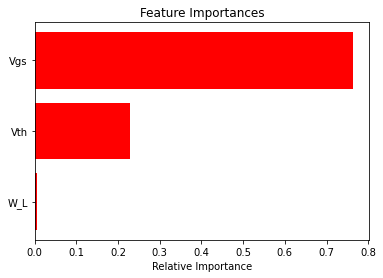

In [56]:
features = ['W_L','Vgs','Vth']
importances = rf.feature_importances_
indices = np.argsort(importances)

plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='red', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

#### 🆘 Important
We can observe that the "Vgs" (Voltage between gate and source) is the most important feature of our dataset. On the other hand, the feature "W_L" (Mobility factor/coefficient) is the least important.

## CONCLUSION !!! 🏁

We can observe that, at all the regression algorithms we used, we are getting an overfitted model. We definetly do not want that because our model can not generalise well for a different data set. That is why we are going to develop a DNN afterwards, to avoid this overfitting and get better results.

<br>

# Deep Neural Network Creation 🧠

From here and on we will leave the classical ML algorithms, and we will start creating a DNN for our application.

While building our DNN model, we need to choose an activation function. We are going to try and train our model by using the relu, sigmoid and tanh.

<img src="Activation-Functions-ReLU-Tanh-Sigmoid.png" style="width:600px;height:100pz"/>


## RELU

#### Builds a DNN model from user input (RELU).

In [57]:
def build_model(num_layers=1, architecture=[32],act_func='relu', 
                input_dim=2, output_class=10):
    
  """
  num_layers   --> Number of hidden layers
  architecture --> Architecture of the hidden layers (densely connected)
  act_func     --> Activation function ('relu','tanh','sigmoid')
  input_dim  --> Dimension of the input vector
  output_class --> Number of classes in the output vector
  """

  layers=[tf.keras.layers.Dense(input_dim,input_dim=input_dim)]
  if act_func=='relu':
    activation=tf.nn.relu
  elif act_func=='tanh':
    activation=tf.nn.tanh
  elif act_func=='sigmoid':
    activation=tf.nn.sigmoid
    
  for i in range(num_layers):
    layers.append(tf.keras.layers.Dense(architecture[i], activation=tf.nn.relu))
  layers.append(tf.keras.layers.Dense(1))
  
  model = tf.keras.models.Sequential(layers)
  return model

#### Compiles and trains a given Keras model with the given data (RELU). 

In [58]:
def compile_train_model(model,x_train, y_train, callbacks=None,
                        learning_rate=0.002,batch_size=1,epochs=20,verbose=0):
    
  """
  learning_rate --> Learning rate for the optimizer Adam
  batch_size    --> Batch size for the mini-batch optimization
  epochs        --> Number of epochs to trainF
  verbose       --> Verbosity of the training process
  """
  
  model_copy = model
  model_copy.compile(optimizer=tf.keras.optimizers.Adam(lr=learning_rate),
                     loss="mae", metrics=["mae"])
  
  if callbacks is not None:
        model_copy.fit(x_train, y_train, epochs=epochs, batch_size=batch_size,
                 callbacks=[callbacks],verbose=verbose)
  else:
    model_copy.fit(x_train, y_train, epochs=epochs, batch_size=batch_size,
                   verbose=verbose)
  return model_copy

With the following arrangement, we just write one line of code to train the model with the training data supplied as data DataFrame.

In [59]:
mosfet.train_leakage(data)


2022-07-31 19:56:51.619104: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: SSE4.1 SSE4.2 AVX AVX2 FMA
2022-07-31 19:56:51.900561: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2095969999 Hz
2022-07-31 19:56:51.911344: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x562203323df0 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2022-07-31 19:56:51.911405: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2022-07-31 19:56:51.933713: I tensorflow/core/common_runtime/process_util.cc:147] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Train on 13500 samples
Epoch 1/20
13500/13500 [==============================] - 25s 2ms/sample - loss: 12.3652 - mae: 12.3653
Epoch 2/20
13500/13500 [==============================] - 20s 1ms/sample - loss: 6.0476 - mae: 6.0476
Epoch 3/20
13500/13500 [==============================] - 20s 2ms/sample - loss: 3.9319 - mae: 3.9318
Epoch 4/20
13500/13500 [==============================] - 20s 2ms/sample - loss: 3.2796 - mae: 3.2796
Epoch 5/20
13500/13500 [==============================] - 20s 1ms/sample - loss: 2.7634 - mae: 2.7634
Epoch 6/20
13500/13500 [==============================] - 22s 2ms/sample - loss: 2.4146 - mae: 2.4146
Epoch 7/20
13500/13500 [==============================] - 21s 2ms/sample - loss: 2.1705 - mae: 2.1705
Epoch 8/20
13500/13500 [==============================] - 22s 2ms/sample - loss: 1.9630 - mae: 1.9630
Epoch 9/20
13500/13500 [==============================] - 23s 2ms/sample - loss: 1.7770 - mae: 1.7770
Epoch 10/20
13500/13500 [==============================] 

In [60]:
m1_trained = mosfet.leakage_model

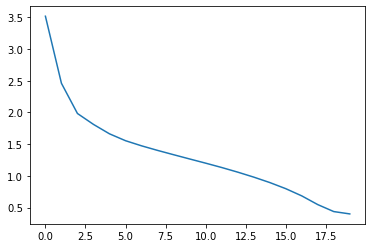

In [61]:
plt.plot(np.sqrt(m1_trained.history.history['mae']))
plt.show()

## TANH

* Now we are going to change our activation function from RELU to tahn.

#### Builds a DNN model from user input (tanh).

In [62]:
#  Builds a DNN model from user input
def build_model(num_layers=1, architecture=[32],act_func='tanh', 
                input_dim=2, output_class=10):
    
  """
  num_layers   --> Number of hidden layers
  architecture --> Architecture of the hidden layers (densely connected)
  act_func     --> Activation function ('relu','sigmoid','tanh')
  input_dim  --> Dimension of the input vector
  output_class --> Number of classes in the output vector
  """

  layers=[tf.keras.layers.Dense(input_dim,input_dim=input_dim)]
  if act_func=='relu':
    activation=tf.nn.relu
  elif act_func=='tanh':
    activation=tf.nn.tanh
  elif act_func=='sigmoid':
    activation=tf.nn.sigmoid
    
  for i in range(num_layers):
    layers.append(tf.keras.layers.Dense(architecture[i], activation=tf.nn.tanh))
  layers.append(tf.keras.layers.Dense(1))
  
  model = tf.keras.models.Sequential(layers)
  return model

#### Compiles and trains a given Keras model with the given data (tanh). 

In [63]:
def compile_train_model(model,x_train, y_train, callbacks=None,
                        learning_rate=0.002,batch_size=1,epochs=20,verbose=0):
    
  """
  learning_rate --> Learning rate for the optimizer Adam
  batch_size    --> Batch size for the mini-batch optimization
  epochs        --> Number of epochs to train
  verbose       --> Verbosity of the training process
  """
  
  model_copy = model
  model_copy.compile(optimizer=tf.keras.optimizers.Adam(lr=learning_rate),
                     loss="mae", metrics=["mae"])
  
  if callbacks is not None:
        model_copy.fit(x_train, y_train, epochs=epochs, batch_size=batch_size,
                 callbacks=[callbacks],verbose=verbose)
  else:
    model_copy.fit(x_train, y_train, epochs=epochs, batch_size=batch_size,
                   verbose=verbose)
  return model_copy

With the following arrangement, we just write one line of code to train the model with the training data supplied as data DataFrame.

In [64]:
mosfet.train_leakage(data)


Train on 13500 samples
Epoch 1/20
13500/13500 [==============================] - 30s 2ms/sample - loss: 9.4134 - mae: 9.4134
Epoch 2/20
13500/13500 [==============================] - 29s 2ms/sample - loss: 5.1566 - mae: 5.1566
Epoch 3/20
13500/13500 [==============================] - 21s 2ms/sample - loss: 4.0783 - mae: 4.0783
Epoch 4/20
13500/13500 [==============================] - 21s 2ms/sample - loss: 3.6777 - mae: 3.6777
Epoch 5/20
13500/13500 [==============================] - 21s 2ms/sample - loss: 3.5320 - mae: 3.5320
Epoch 6/20
13500/13500 [==============================] - 21s 2ms/sample - loss: 3.4852 - mae: 3.4852
Epoch 7/20
13500/13500 [==============================] - 23s 2ms/sample - loss: 3.4473 - mae: 3.4473
Epoch 8/20
13500/13500 [==============================] - 22s 2ms/sample - loss: 2.9208 - mae: 2.9208
Epoch 9/20
13500/13500 [==============================] - 22s 2ms/sample - loss: 2.4840 - mae: 2.4840
Epoch 10/20
13500/13500 [==============================] - 

In [65]:
m1_trained = mosfet.leakage_model


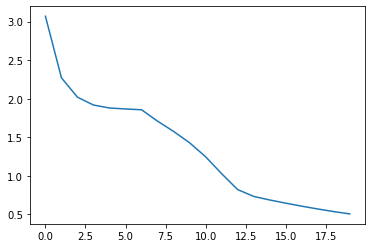

In [66]:
plt.plot(np.sqrt(m1_trained.history.history['mae']))
plt.show()

## SIGMOID

* Now we are going to change our activation function from tahn to sigmoid.

#### Builds a DNN model from user input (sigmoid).

In [67]:
#  Builds a DNN model from user input
def build_model(num_layers=1, architecture=[32],act_func='sigmoid', 
                input_dim=2, output_class=10):
    
  """
  num_layers   --> Number of hidden layers
  architecture --> Architecture of the hidden layers (densely connected)
  act_func     --> Activation function ('relu','sigmoid','tanh')
  input_dim  --> Dimension of the input vector
  output_class --> Number of classes in the output vector
  """

  layers=[tf.keras.layers.Dense(input_dim,input_dim=input_dim)]
  if act_func=='relu':
    activation=tf.nn.relu
  elif act_func=='tanh':
    activation=tf.nn.tanh
  elif act_func=='sigmoid':
    activation=tf.nn.sigmoid
    
  for i in range(num_layers):
    layers.append(tf.keras.layers.Dense(architecture[i], activation=tf.nn.sigmoid))
  layers.append(tf.keras.layers.Dense(1))
  
  model = tf.keras.models.Sequential(layers)
  return model

#### Compiles and trains a given Keras model with the given data (sigmoid). 

In [68]:
def compile_train_model(model,x_train, y_train, callbacks=None,
                        learning_rate=0.002,batch_size=1,epochs=20,verbose=0):
    
  """
  learning_rate --> Learning rate for the optimizer Adam
  batch_size    --> Batch size for the mini-batch optimization
  epochs        --> Number of epochs to trainF
  verbose       --> Verbosity of the training process
  """
  
  model_copy = model
  model_copy.compile(optimizer=tf.keras.optimizers.Adam(lr=learning_rate),
                     loss="mae", metrics=["mae"])
  
  if callbacks is not None:
        model_copy.fit(x_train, y_train, epochs=epochs, batch_size=batch_size,
                 callbacks=[callbacks],verbose=verbose)
  else:
    model_copy.fit(x_train, y_train, epochs=epochs, batch_size=batch_size,
                   verbose=verbose)
  return model_copy

With the following arrangement, we just write one line of code to train the model with the training data supplied as data DataFrame.

In [69]:
mosfet.train_leakage(data)

Train on 13500 samples
Epoch 1/20
13500/13500 [==============================] - 24s 2ms/sample - loss: 11.3778 - mae: 11.3778
Epoch 2/20
13500/13500 [==============================] - 20s 1ms/sample - loss: 8.4000 - mae: 8.4000
Epoch 3/20
13500/13500 [==============================] - 20s 2ms/sample - loss: 6.5653 - mae: 6.5653
Epoch 4/20
13500/13500 [==============================] - 22s 2ms/sample - loss: 5.4872 - mae: 5.4872
Epoch 5/20
13500/13500 [==============================] - 22s 2ms/sample - loss: 4.7637 - mae: 4.7637
Epoch 6/20
13500/13500 [==============================] - 19s 1ms/sample - loss: 4.2594 - mae: 4.2594
Epoch 7/20
13500/13500 [==============================] - 21s 2ms/sample - loss: 3.9219 - mae: 3.9219
Epoch 8/20
13500/13500 [==============================] - 21s 2ms/sample - loss: 3.7085 - mae: 3.7085
Epoch 9/20
13500/13500 [==============================] - 20s 1ms/sample - loss: 3.5866 - mae: 3.5866
Epoch 10/20
13500/13500 [==============================] 

In [70]:
m1_trained = mosfet.leakage_model


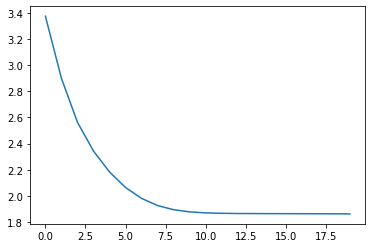

In [71]:
plt.plot(np.sqrt(m1_trained.history.history['mae']))
plt.show()

## CONCLUSION !!! 🏁

We can observe, after our training is completed (for all three activation functions), the mean absolute error (mae) that is given after each epoch is finished.

We can say that after the full completion of the three trainings, the use of the RELU activation function, is the most suitable for our application, as it gives us the smallest mae (mean absolute error) after the 20th (last) epoch.